# The State of Open Data on School Bullying and Harassment
By [Two Sigma Data Clinic](https://www.twosigma.com/dataclinic)

On March 6th, 2018, the Two Sigma Data Clinic hosted "The State of Open Data on School Bullying and Harassment" as part of [NYC Open Data Week](https://www.open-data.nyc/), a weeklong celebration of the city's [open data portal](https://opendata.cityofnewyork.us/). The two-hour event featured a comparison of federal and local datasets about New York City schools, followed by a panel discussion on what open data can reveal—and conceal—about this important school safety issue.

This notebook documents our comparative analysis of the bullying/harassment data in the New York City Department of Education's School Survey of parents, students, and teachers in NYC public schools, and the federal Office for Civil Rights's Civil Rights Data Collection Survey, which is filled out by all public schools and districts nationwide, both for the 2013-14 school year.

## Data Sources

The [raw Excel file](http://schools.nyc.gov/documents/misc/2014%20Public%20Data%20File%20SUPPRESSED.xlsx) of the NYC survey responses comes from the New York City Department of Education (NYCDOE). The full page for the 2014 NYC School Survey Results (representing the 2013-14 school year) is [here](http://schools.nyc.gov/Accountability/tools/survey/2014+NYC+School+Survey+Results). NYCDOE posts archived survey information [here](http://schools.nyc.gov/Accountability/tools/survey/SurveyArchives.htm).

The [raw file](https://inventory.data.gov/dataset/2acc601e-9806-4dff-b144-f8a5e7c095b8/resource/3dc84a95-526a-4b90-aacd-72f60d4fecbc/download/crdc201314csv.zip) of the federal civil rights survey responses comes from the U.S. Department of Education (ED)'s Office for Civil Rights (OCR), available on [Data.gov](https://catalog.data.gov/dataset/civil-rights-data-collection-2013-14). The full page for the Civil Rights Data Collection for the 2013-14 school year is [here](https://www2.ed.gov/about/offices/list/ocr/docs/crdc-2013-14.html). OCR also hosts a data portal with information from earlier years [here](https://ocrdata.ed.gov/).

For details on these pre-processing of these datasets, see the notebooks in the `processing/` folder referenced under the Load Data section below.

## Import Python libraries and set working directories

In [17]:
from itertools import product
import os
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import csv
import time
from sklearn.linear_model import LogisticRegression
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [18]:
intermediate_dir = os.path.join(os.getcwd(), 'data', 'intermediate')
output_dir = os.path.join(os.getcwd(), 'data', 'output')

## Load data

Let's read in the combined dataset, containing information from both surveys. The data is saved as a [feather](https://blog.cloudera.com/blog/2016/03/feather-a-fast-on-disk-format-for-data-frames-for-r-and-python-powered-by-apache-arrow/) file in the `data/output` folder. It is also available a csv file in the same folder. For details on data cleaning and pre-processing, see the notebooks in the `processing/` folder, specifically `processing/01_combine_surveys.ipynb` and `processing/02_add_school_characteristics.ipynb`.

In [19]:
df = pd.read_feather(
    os.path.join(output_dir, 'combined_data.feather')
)

## NYC School Survey

Let's first look at the responses to the NYC School Survey, which is filled out by parents, teachers, and grade 6-12 students. 

## Plot the distribution of responses on the NYC School Survey

Let's plot (using the `ggplot2` library in R) the percent of respondents selecting each answer value to the two NYC School Survey questions about bullying/harassment: a general question about bullying/harassment, and a specific question about bullying/harassment based on differences. Since each group has four answer choices, we rank orderer these from 1 to 4, going from weak to strong feelings, by creating a 4-point ordinal scale. Note we exclude "Don't Know" responses from Parents. For more information, see  `processing/nyc_school_survey.ipynb`.

### Set up [`rpy2`](https://rpy2.bitbucket.io/) in order to run R in this Jupyter notebook

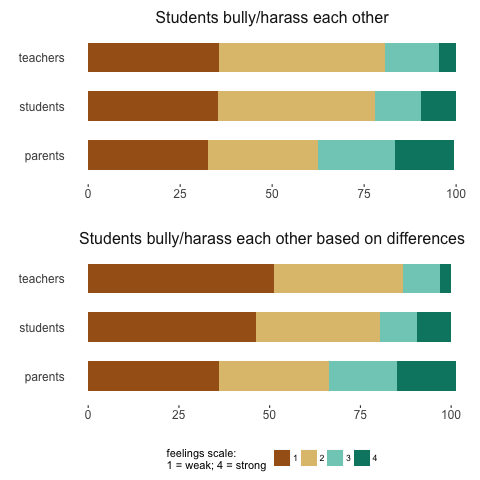

In [20]:
%%R -i df
library('dplyr')
library('ggplot2')
library('tidyr')

survey.answers <- df %>% select(dbn, school_name, answer_code, grep('perc_harass', names(df)))
survey.answers.long <- survey.answers %>% gather(category, value, -answer_code, -dbn, -school_name, 
                                                 -answer_code)
survey.answers.long$population <- ifelse(grepl('parents', survey.answers.long$category), 'parents',
                                         ifelse(grepl('students', survey.answers.long$category), 'students', 
                                                'teachers'))
survey.answers.long$question <- ifelse(grepl('differences', survey.answers.long$category), 'differences', 'harass')
survey.answers.long.agg <- survey.answers.long %>% 
                   group_by(answer_code, question, population) %>% 
                   summarise(response = mean(value, na.rm = T))
survey.answers.long.agg$q <- ifelse(survey.answers.long.agg$question == 'differences', 
                                    'Students bully/harass each other based on differences', 
                                    'Students bully/harass each other')
survey.answers.long.agg$col <- ifelse(survey.answers.long.agg$answer_code == 3, '#80cdc1', 
                              ifelse(survey.answers.long.agg$answer_code == 4, '#018571', 
                              ifelse(survey.answers.long.agg$answer_code == 2, '#dfc27d', '#a6611a')))
highs <- survey.answers.long.agg %>% filter(answer_code >= 3)
lows <- survey.answers.long.agg %>% filter(answer_code < 3)

p <- ggplot() + 
           geom_bar(data = survey.answers.long.agg[order(survey.answers.long.agg$answer_code, decreasing = T),],
           aes(x = population, y = response, fill = factor(answer_code, levels = c(
           '4', '3', '2', '1'))), 
           stat="identity", width = 0.6) + 
           coord_flip() + 
           facet_wrap(~q, nrow = 2, scales = 'free') + labs(y = '', x = '') + 
           theme(legend.position = 'bottom') +
           labs(fill = 'feelings scale:\n1 = weak; 4 = strong ') + guides(fill = guide_legend(reverse=T)) +
           scale_fill_manual(values = c('#018571', '#80cdc1', '#dfc27d', '#a6611a')) 
    
p + theme(panel.background = element_rect(fill = "white"), axis.text.x = element_text(size = 12),
         axis.text.y = element_text(size = 12), strip.text = element_text(size  = 16),
         panel.spacing = unit(2, "lines"), axis.ticks.y = element_line(size = 0),
         strip.background = element_rect(fill = "white")) + labs(x = '', y = '')

## Calculate standarized scores for each school, based on responses to the NYC School Survey

Because we have an ordinal scale representing the responses, we can compute a "score" for each school by taking a weighted average of the response percentages in each category. 

In [21]:
def condense_to_score(df_orig, weight_cols):
    df = df_orig.copy()
    df[weight_cols] = df[weight_cols] / 100.0
    score_cols = [c + '_score' for c in weight_cols]
    for w, s in zip(weight_cols, score_cols):
        df[s] = df[w] * df['answer_code']
    df = df[['dbn', 'school_name'] + score_cols].groupby(['dbn', 'school_name']).sum(min_count = 1)
    return df

In [22]:
survey_cols = [''.join(tup) for tup in product(['perc_harass_'],
                                               ['', 'differences_'],
                                               ['parents', 'students', 'teachers'])]

In [23]:
unique_cols = [c for c in df.columns if c not in set(survey_cols + ['answer_code'])]
df_schools = df[unique_cols].drop_duplicates()
df_scores = condense_to_score(df, survey_cols).reset_index()

To understand where each school falls with respect to the citywide average, we can compute the citywide average and then  calculate a "z-score" for each school that standardizes the school's score with respect to this average. Schools with higher-than-average feelings about bullying/harassment will have positive z-scores, and schools with lower-than-avrage feelings will have negative z-scores.

In [24]:
def calculate_z_score(df_orig):
    df = df_orig.copy()
    score_cols = [c for c in df_scores.columns if 'score' in c]
    z_score_cols = [c + '_z' for c in score_cols]
    for s, z in zip(score_cols, z_score_cols):
        df[z] = (df[s] - df[s].agg('mean')) / df[s].agg('std')
    return df

In [25]:
df_scores_z = calculate_z_score(df_scores)
df_merge = pd.merge(df_schools, df_scores_z, on = ['dbn', 'school_name'])

### How correlated are responses?


Let's generate a heatmap to see how correlated respones are between each of the questions.

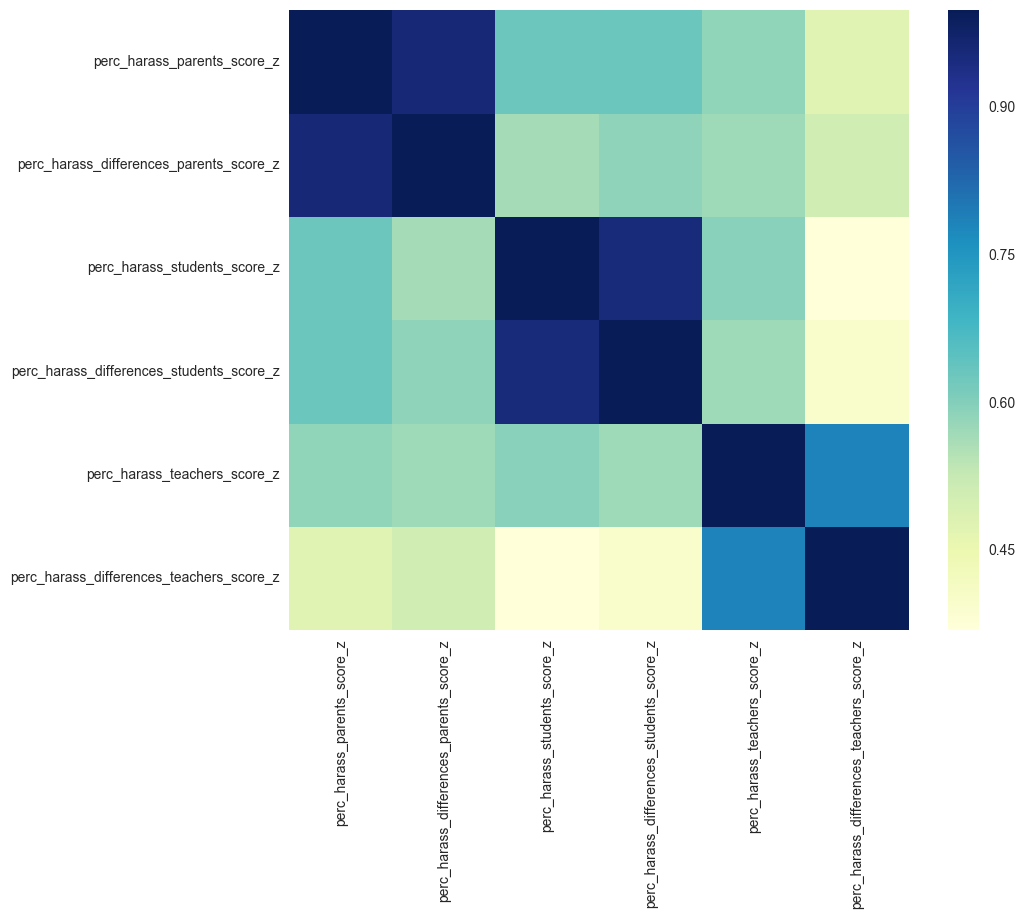

In [26]:
m = df_scores_z[['perc_harass_parents_score_z', 'perc_harass_differences_parents_score_z', 
                 'perc_harass_students_score_z', 'perc_harass_differences_students_score_z', 
                 'perc_harass_teachers_score_z', 'perc_harass_differences_teachers_score_z']]

# Compute the correlation matrix
corr = m.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, cmap='YlGnBu', annot_kws={"size": 18})

Within each response group, the two bullying/harassment questions are strongly correlated, as shown by the dark blue squares on the diagonal. So, students agree with students, parent with parents, and so on. Student + parent scores tend to be more correlated with each other than teachers + students or teachers + parents.

### Where do teachers and students appear to disagree on the NYC school survey?

Let's look at teacher and student agreement within individual schools. Here we plot the difference in scores between teachers and students on the y axis where each dot represents a school. Schools are ranked by total enrollment along the x-axis. If there was perfect agreement between teachers and students, the orange trend line would be horizontal but interestingly, we notice a slight trend of disagreement that changes with school enrollment – in smaller schools, teachers tend to perceive more bullying and harassment than students but in larger schools, this is reversed. Note, however, that the correlation is small.

[1] -0.2598237


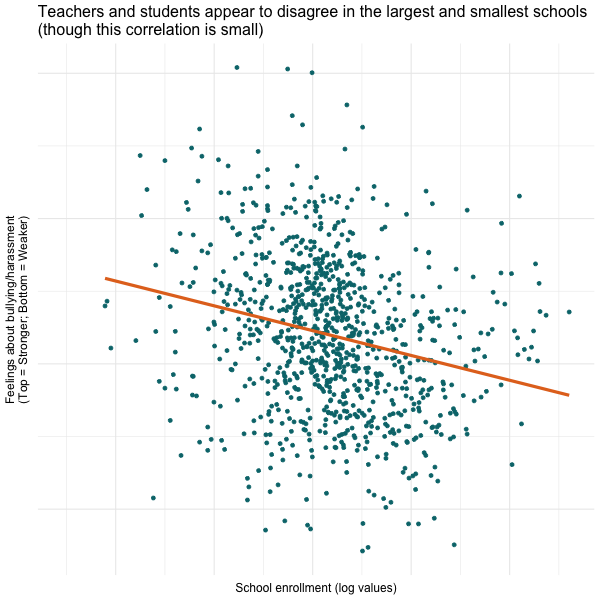

In [27]:
%%R -i df_merge -w 600 -h 600
library('ggplot2')
library('dplyr')
library('forcats')

df_merge$school_sorted <- as.numeric(fct_reorder(as.factor(df_merge$dbn), 
                                          df_merge$total_enrollment))

df_merge <- df_merge %>% mutate(students_teachers_diff = perc_harass_differences_teachers_score_z - perc_harass_differences_students_score_z) 

plot <- ggplot(df_merge,
       aes(x = log(total_enrollment), y = students_teachers_diff)) + 
       geom_point(color = '#00747A') + 
       labs(x = 'School enrollment (log values)', 
            y = 'Feelings about bullying/harassment\n(Top = Stronger; Bottom = Weaker)') +
       theme_minimal() +
       geom_smooth(method = 'lm', se = F, color = '#E37222', size = 1.5)  + 
       theme(axis.text = element_blank(), 
             axis.title=element_text(size = 12),
             axis.ticks.x = element_blank(), plot.title = element_text(size=16)) +
      ggtitle('Teachers and students appear to disagree in the largest and smallest schools\n(though this correlation is small)')

print(cor(df_merge$students_teachers_diff, log(df_merge$total_enrollment), use = 'complete.obs', method = 'spearman'))
plot(plot)

## Federal civil rights data

Now let's look at the responses to the federal Office for Civil Rights's Civil Rights Data Collection survey, which is filled out by the schools.

When we refer to allegations, we mean either race, sex, or disability-based allegations as we did not examine each category independently. Also note that in addition to the number of allegations, the Office for Civil Rights collects the number of students reported to be bullied/harassed and the number of students disciplined for bullying/harassment. For ease of comparison with the NYC School Survey, we only used allegations in our analysis. For more information, see  `processing/federal_civil_rights_survey.ipynb`.

In [28]:
df_merge['max_allegations'] = df_merge[['allegations_harass_sex', 
                                       'allegations_harass_race',
                                       'allegations_harass_dis']].max(axis = 1)

df_merge['allegations_binary'] = np.where(df_merge['max_allegations'] == 0, 0, 1)
df_merge['allegations_binary'] = np.where(pd.isnull(df_merge['max_allegations']), np.nan, df_merge['allegations_binary'])
df = pd.merge(df, df_merge[['dbn', 'allegations_binary', 'max_allegations']], on = 'dbn', how = 'outer')

### How many schools report bullying/harassment allegations?

Let's plot (using the `ggplot2` library in R) the percent of NYC schools reporting 0, 1, and more than 1 allegation of bullying/harassment.

[1] "1314 schools, or 75 percent of NYC schools report zero allegations of bullying/harassment to the federal Office for Civil Rights."


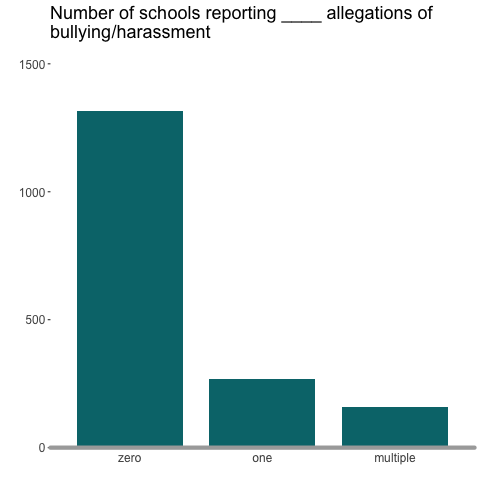

In [29]:
%%R -i df_merge
library('ggplot2')
library('dplyr')
library('forcats')


df_merge$allegations_cat <- ifelse(df_merge$max_allegations == 0, 'zero', 
                                    ifelse(df_merge$max_allegations == 1, 'one', 
                                           'multiple'))
bar <- df_merge %>% group_by(allegations_cat) %>% summarise(n = n()) %>% mutate(perc = n/sum(n) * 100) %>% filter(is.na(allegations_cat) == F)

bar <- bar %>%
    mutate(allegations_cat = fct_reorder(allegations_cat, n, .desc = TRUE)) 

plot <- ggplot(bar, aes(x = allegations_cat, y = n)) + geom_bar(stat='identity',
                                                        width = .8, 
                                                        fill = '#00747A') + 
labs(x = '', y = '') + theme(panel.background = element_rect(fill = "white"), 
                             axis.ticks.x = element_blank(), 
                             axis.text.y = element_text(size = 12),
                             axis.text.x = element_text(size = 12),
                            ) + 
  scale_y_continuous(limits = c(0, 1500), expand = c(0, 0)) +
  theme(axis.line.x = element_line(color="darkgrey", size = 2), plot.title = element_text(size = 18)) +
  ggtitle('Number of schools reporting ____ allegations of\nbullying/harassment\n') 


print(paste(bar[bar$allegations_cat == 'zero',]$n, 'schools, or', round(bar[bar$allegations_cat == 'zero',]$perc), 
             "percent of NYC schools report zero allegations of bullying/harassment to the federal Office for Civil Rights."))

plot(plot)

Let's use the full dataset (created in `processing/federal_civil_rights_survey.ipynb`) to see how this compares with the percent of schools reporting zero allegations nationwide.

In [30]:
ocr_nationwide = pd.read_feather(os.path.join(intermediate_dir, 'federal_ocr_survey.feather'))
print(str(ocr_nationwide.allegations_harass_ind.value_counts()[0]) + 
      " schools, or " + str(round(ocr_nationwide.allegations_harass_ind.value_counts(normalize = True)[0] * 100)) + 
      " percent of schools nationwide report zero allegations of bullying/harassment to the federal Office for Civil Rights.")

76916 schools, or 81.0 percent of schools nationwide report zero allegations of bullying/harassment to the federal Office for Civil Rights.


## Comparing the NYC School Survey and the federal civil rights data 

Now let's compare the two surveys.

### Characteristics of schools with 0 or 1+ allegations

Using this classification of zero versus one or more, let's explore the differences in school characteristics.

In [34]:
f = csv.writer(open(os.path.join(intermediate_dir, 't_stats.csv'), 'w'))
f.writerow(['variable', 't', 'p'])
for var in df_merge.drop(['allegations_binary'], axis = 1).columns:
    try:
        group1 = df_merge[df_merge['allegations_binary'] == 0][var].astype(float).dropna()
        group2 = df_merge[df_merge['allegations_binary'] == 1][var].astype(float).dropna()
        t, p = ttest_ind(group1, group2, equal_var=False)
        f.writerow([var, t, p])
    except:
        continue

time.sleep(2)

In [35]:
t_stats = pd.read_csv(os.path.join(intermediate_dir, 't_stats.csv'))
t_stats = t_stats.loc[abs(t_stats['t']) > 1.96] 
t_stats.columns.tolist() # to get significant variables
grouped = df_merge.loc[df_merge['allegations_binary'].notnull()].groupby('allegations_binary')

grouped_means = grouped.mean()

grouped_means.reset_index(inplace = True)

grouped_means[['allegations_binary', 'total_enrollment', 'perc_students_with_disabilities', 'perc_english_language_learners',
               'perc_harass_differences_parents_score_z', 'perc_harass_differences_students_score_z', 
               'perc_harass_differences_teachers_score_z']]

,allegations_binary,total_enrollment,perc_students_with_disabilities,perc_english_language_learners,perc_harass_differences_parents_score_z,perc_harass_differences_students_score_z,perc_harass_differences_teachers_score_z
0,0.0,576.007987,18.322969,13.753462,-0.116755,-0.146220,-0.150437
1,1.0,713.007264,19.261490,11.838821,0.365455,0.262559,0.458606


![characteristics](img/characteristics.PNG)

Schools with 1+ allegation of bullying & harassment have a significantly higher total school enrollment (which is to be expected given we are grouping based on counts) and percent of students with disabilities, but a lower percent of English language learners. Schools reporting allegations had on average much higher z-scores for the NYC survey, indicating that perceived harassment is generally higher in schools with at least one federal allegation of bullying, suggesting general agreement between the federal and local data sources. 

## How much do the two surveys (dis)agree?

Although the above section shows that survey agreement is generally in the "right" direction (namely federal allegations are associated with student, teacher, and parent perceptions of bullying), let's take a closer look at individual schools.

Let's create a dataframe, `df_all_the_time`, that filters for the percentage of students/parents/teachers saying bullying is happening all of the time.

In [36]:
df_all_the_time = df.loc[df['answer_code'] == 4]

Now we can find outliers. For example, here are some schools with a high percentage of students saying bullying based on differences happens all of the time but that reported 0 allegations to the federal Civil Rights Data Collection. (Each row below is a separate school.)

In [37]:
df_all_the_time[['dbn', 
                 'perc_harass_differences_students']].sort_values(by = 'perc_harass_differences_students', ascending = False).head()

,dbn,perc_harass_differences_students
3835,19K306,34.730539
3619,18K068,33.078101
3935,19K663,30.645161
3579,17K587,28.048780
2511,11X541,27.777778


As shown above, there is a school where nearly 35 percent of students said bullying based on differences was happening all of the time in the NYC School Survey but that reported 0 allegations to the federal Office for Civil Rights.

On the other hand, here are some schools that reported 1 or more allegations of bullying to the federal Civil Rights Data Collection but where a low percentage of students said bullying was happening all of the time in the NYC School Survey (Each row below is a separate school.)

In [38]:
df_all_the_time.loc[df['allegations_binary'] == 1][['dbn', 
                                                    'perc_harass_differences_students', 'max_allegations']].sort_values(by = 'max_allegations', ascending = False).head()

,dbn,perc_harass_differences_students,max_allegations
6675,84M388,0.478469,26.0
6611,84M279,13.483146,11.0
6319,84K359,21.698113,10.0
6459,84K730,13.452915,9.0
5027,26Q172,16.723549,8.0


As shown above, there is a school that reported 26 allegations of harassment to the federal Office for Civil Rights, but where less than 1 percent of students said bullying was happening all the time.

Let's plot the distribution of students responding that bullying based on differences is happening all of the time among schools that report 0 and and 1+ allegations. Here we will remove schools with question response rates < 75%.

The dark teal(top plot) represents schools reporting 0 allegations and the light teal (bottom plot) represents school reporting 1+ allegations.

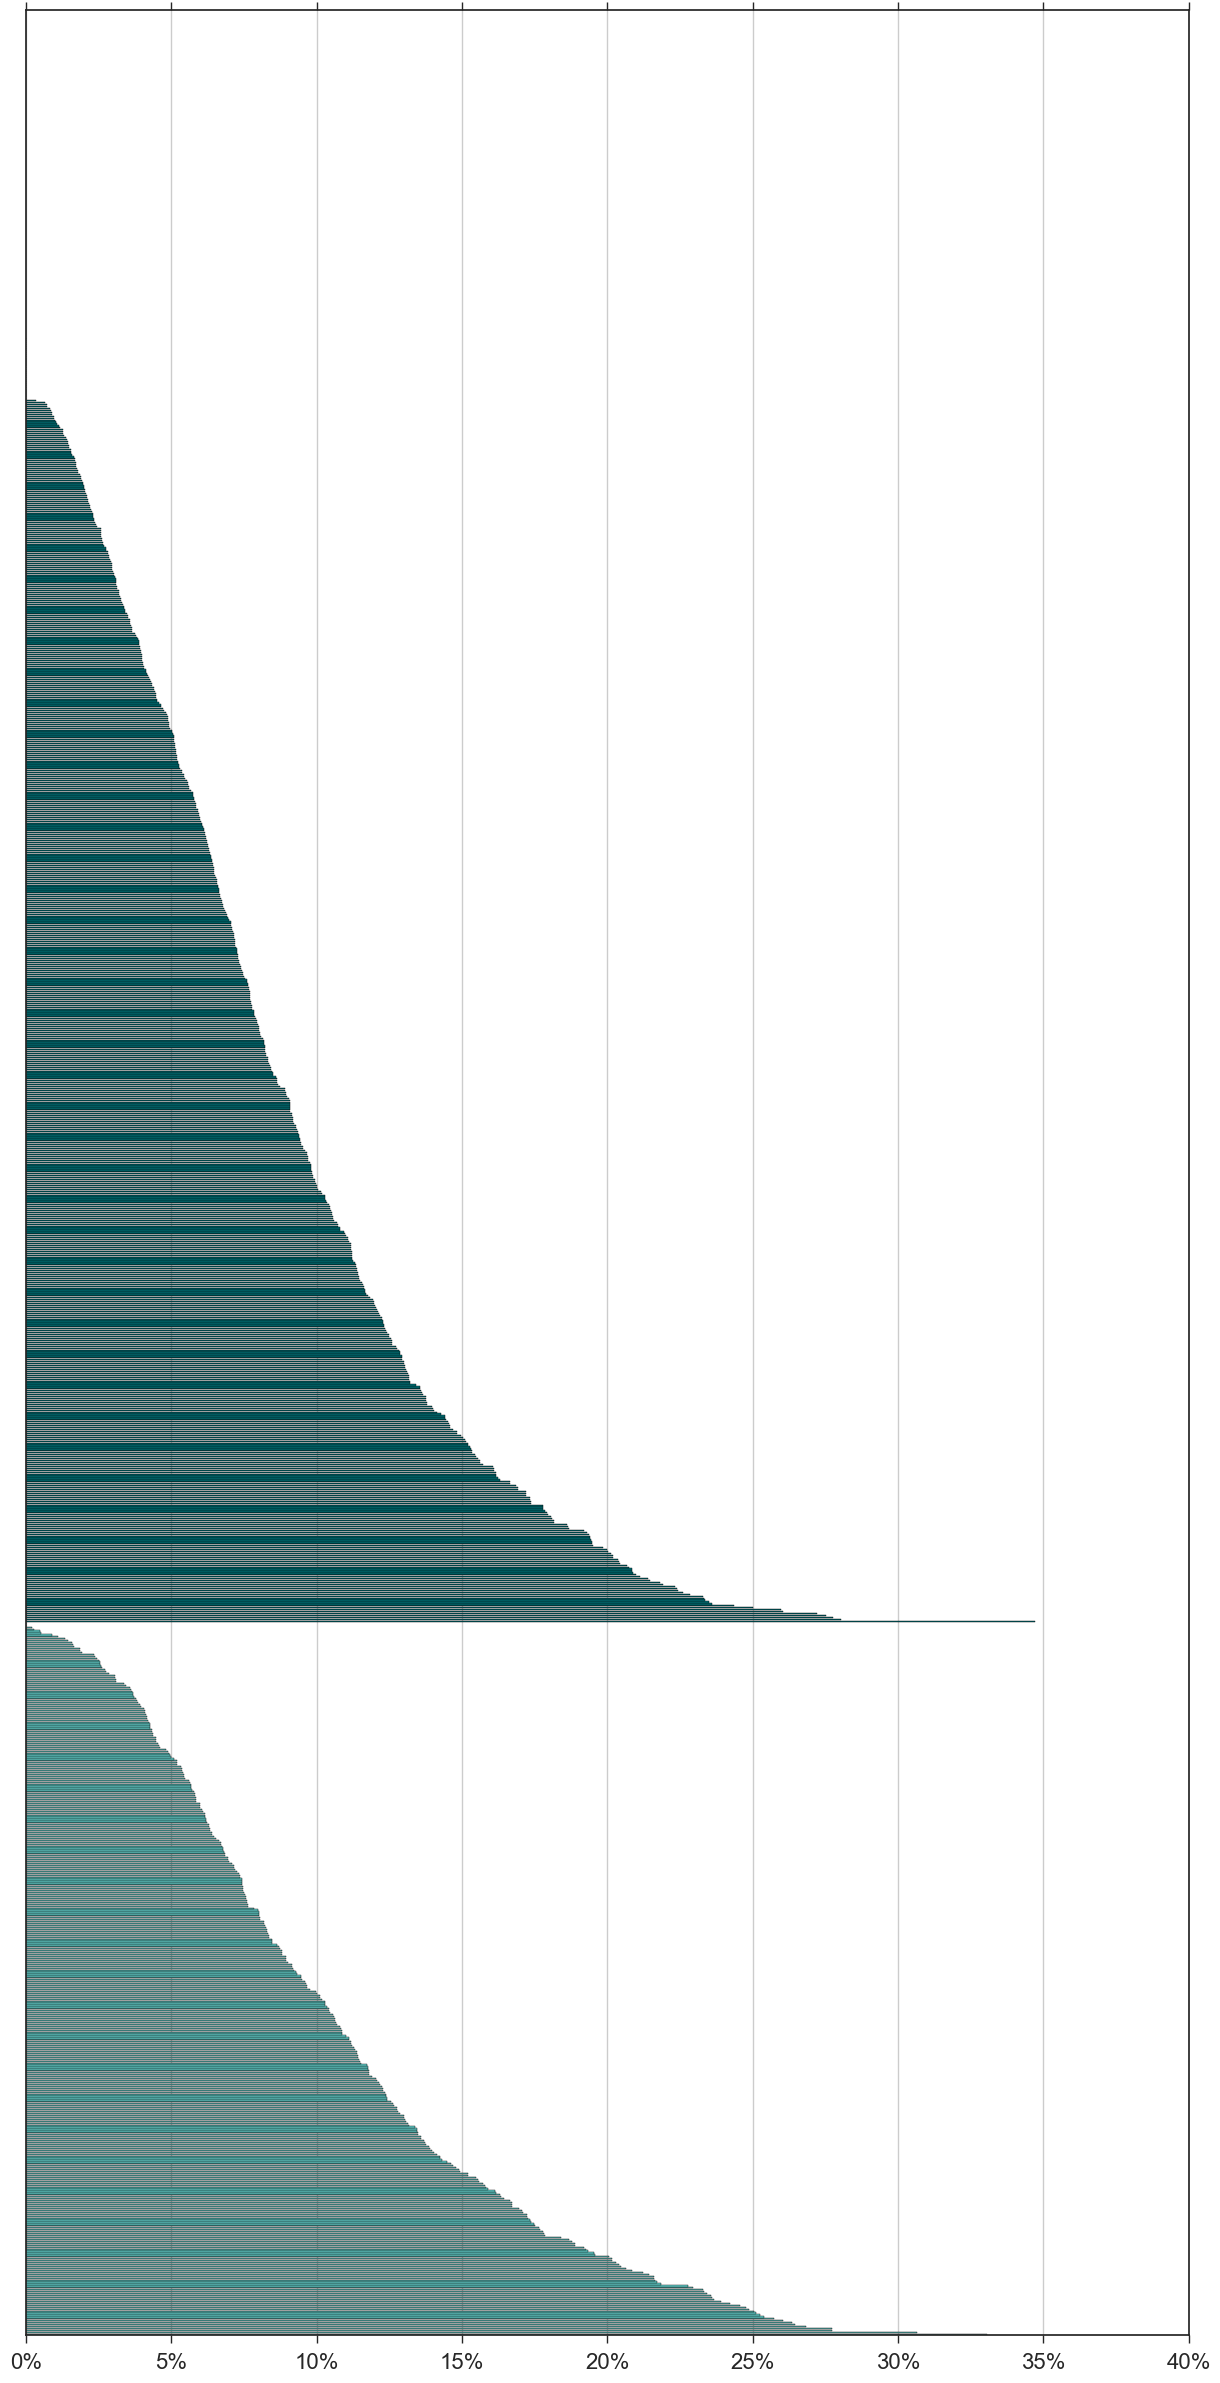

In [39]:
df_all_the_time = df_all_the_time[~(df_all_the_time['perc_harass_differences_students'].isnull())]
df_all_the_time_rr = df_all_the_time[df_all_the_time['question_rr_harass_differences_students'] >= 75.0]
allegations_mags = [1.0 if x else -1.0 for x in df_all_the_time_rr['allegations_harass_ind'].values]
df_all_the_time_rr['mag_all'] = df_all_the_time_rr['perc_harass_differences_students'] * (allegations_mags)
df_all_the_time_rr['mag_color'] = df_all_the_time_rr['allegations_harass_ind'].apply(lambda i: '#63CECA' if i else '#00747A')
df_all_the_time_rr = df_all_the_time_rr.sort_values(['allegations_harass_ind', 'perc_harass_differences_students'], ascending=False)

base_plot_size = 15.0
for df in [df_all_the_time_rr]:
    plt.style.use('seaborn-ticks')
    f, ax = plt.subplots(figsize=(base_plot_size, base_plot_size * 2))
    ax.barh(range(len(df)), df['perc_harass_differences_students'], 0.6, color=df['mag_color'])
    ax.grid()
    ticks = range(0, 41, 5)
    plt.xticks(ticks, [str(abs(t)) + '%' for t in ticks], fontsize=16)
    plt.yticks([])
    plt.show()

### Zones of (dis)agreement

Now let's try to see if we can better characterize what makes a school more or less likely to show agreement between data sources. To do this, we need to first define what agreement and disagreement are. 

For the federal data, we have a binary classification of 0 allegations or 1+ allegations. Similarly, for the NYC school survey we can categorize schools into those with a low perception of bullying on the bottom versus those with a high perception on the top. To figure out what constitutes "low" and "high" perceptions, we ranked schools using z-scores and used a threshold to define "low" perception that would bucket roughly the same percent of schools as those with zero allegations ("high" perception would be the rest). We then mapped schools into zones of agreement and disagreement. 
-	Agreement is defined as schools with zero allegations + low perception OR at least one allegation + high perception 
-	Conversely, disagreement refers to schools with zero allegations + high perception OR one plus allegation + low perception. 

![zones](img/zones_disagreement.PNG)

Now let's take a look at the data for each school to demonstrate how to translate our conceptual framework into an agreement versus disagreement metric for analysis.

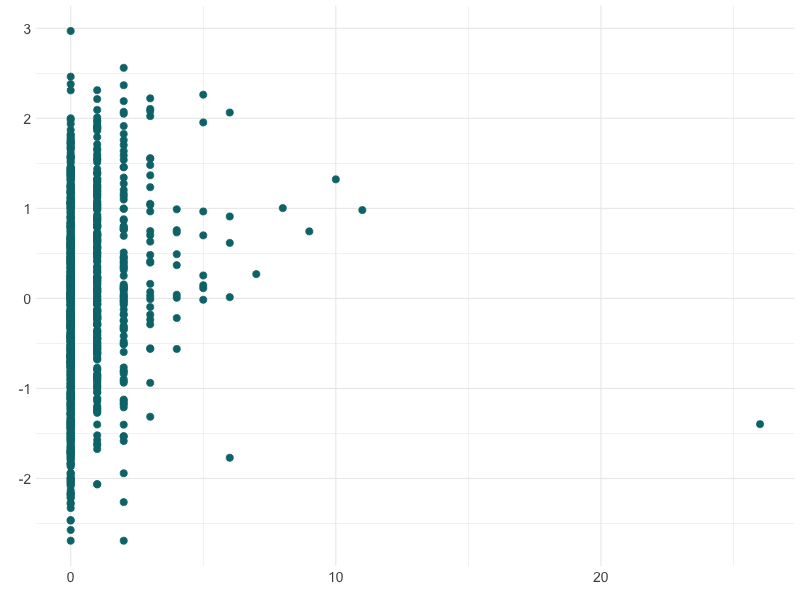

In [42]:
%%R -i df_merge -w 800 -h 600
library('ggplot2')

ggplot(df_merge, aes(x = max_allegations, y = perc_harass_differences_students_score_z)) + 
       geom_point(color = '#00747A', size = 3) + 
       labs(x = '', y = '') + theme_minimal() +
       theme(axis.text = element_text(size = 14),
             axis.ticks.x = element_blank())

Here we can see the outlier we discussed earlier with 26 allegations + low student perceptions of bullying.

### Classifying schools into agreement/disagreement zones

~75 percent of schools have 0 allegations and ~25 percent have 1 or more allegations. We take a look at the (bottom) 75th & (top) 25th percentile of scores for parents/students/teachers. For instance, for each question and survey population, we ask: What is the threshold/cutoff score of the bottom 75% of schools? Then, we look at each school's score. If it is lower than this number, we classify the school as having "low" bullying/harassment perceptions, and if it's higher than this number, we classify the school as having "high" bullying/harassment perceptions.

In [43]:
#determine what qualifies as low response rates
rr = ['question_rr_harass_parents', 'question_rr_harass_students', 'question_rr_harass_teachers',
      'question_rr_harass_differences_parents', 'question_rr_harass_differences_students', 'question_rr_harass_differences_teachers']
df_merge[rr].quantile(q=[0.005, 0.01, .05, 0.1]) #response rate cut off 75% corresponds to <.05 of a percent of data.

,question_rr_harass_parents,question_rr_harass_students,question_rr_harass_teachers,question_rr_harass_differences_parents,question_rr_harass_differences_students,question_rr_harass_differences_teachers
0.005,82.258621,86.684785,80.000000,83.516746,89.158928,80.000000
0.010,87.500000,88.276334,84.615385,87.015428,89.783505,84.854701
0.050,91.490426,92.229016,92.307692,90.756759,93.151015,92.592593
0.100,92.727273,93.559322,94.317460,92.093369,94.613821,94.736842


In [44]:
#nan values where response rate <75%
df_merge['avg_score_parents_harass2'] = df_merge['perc_harass_parents_score']
df_merge['avg_score_parents_harass_differences2'] = df_merge['perc_harass_differences_parents_score']
df_merge['avg_score_students_harass2'] = df_merge['perc_harass_students_score']
df_merge['avg_score_students_harass_differences2'] = df_merge['perc_harass_differences_students_score']
df_merge['avg_score_teachers_harass2'] = df_merge['perc_harass_teachers_score']
df_merge['avg_score_teachers_harass_differences2'] = df_merge['perc_harass_differences_teachers_score']

df_merge.loc[df_merge.question_rr_harass_parents < 75, 'avg_score_parents_harass2'] = np.nan
df_merge.loc[df_merge.question_rr_harass_differences_parents < 75, 'avg_score_parents_harass_differences2'] = np.nan
df_merge.loc[df_merge.question_rr_harass_students < 75, 'avg_score_students_harass2'] = np.nan
df_merge.loc[df_merge.question_rr_harass_differences_students < 75, 'avg_score_students_harass_differences2'] = np.nan
df_merge.loc[df_merge.question_rr_harass_parents < 75, 'avg_score_teachers_harass2'] = np.nan
df_merge.loc[df_merge.question_rr_harass_differences_teachers < 75, 'avg_score_teachers_harass_differences2'] = np.nan

#reclassify school type and grade category
df_merge['school_type2'] = df_merge['school_type'].map(lambda x: 'general' if x == 'General Academic' else 'Other' if x == 'Transfer School' 
                                                   else 'Other' if x == 'Career Technical' else 'Other' if x == 'Special Education' else x)
df_merge['school_grade_category2'] = df_merge['school_grade_category'].map(lambda x: 'Elementary' if x == 'Elementary' else 'Elementary' if x == 'Early Childhood' 
                                                   else 'Middle' if x == 'Junior High-Intermediate-Middle' else 'High' if x == 'High school' else 'High' 
                                                                       if x == 'Secondary School' else 'Mixed' if x == 'K-8' else 'Mixed' if x == 'K-12 all grades'
                                                                       else 'Mixed' if x == 'Ungraded' else x)

#classify percentiles for agreement/disagreement metric
alleg = df_merge.allegations_binary.value_counts()
alleg / alleg.sum()

0.0    0.755172
1.0    0.244828
Name: allegations_binary, dtype: float64

In [45]:
survey = ['perc_harass_parents_score_z', 'perc_harass_differences_parents_score_z', 
          'perc_harass_students_score_z', 'perc_harass_differences_students_score_z', 
          'perc_harass_teachers_score_z', 'perc_harass_differences_teachers_score_z']

df_merge[survey].quantile(q=[0.755172])

,perc_harass_parents_score_z,perc_harass_differences_parents_score_z,perc_harass_students_score_z,perc_harass_differences_students_score_z,perc_harass_teachers_score_z,perc_harass_differences_teachers_score_z
0.755172,0.668263,0.700869,0.678322,0.706146,0.68863,0.650904


In [46]:
#create indicator to match percentiles between surveys
df_merge['bin_parents_harass_z'] = df_merge.perc_harass_parents_score_z.map(lambda x: 0 if x <= 0.668263 
                                                                            else 1 if x > 0.668263 else x)
df_merge['bin_parents_harass_differences_z'] = df_merge.perc_harass_differences_parents_score_z.map(lambda x: 0 if x <= 0.700869 
                                                                            else 1 if x > 0.700869 else x)
df_merge['bin_students_harass_z'] = df_merge.perc_harass_students_score_z.map(lambda x: 0 if x <= 0.678322 
                                                                            else 1 if x > 0.678322 else x)
df_merge['bin_students_harass_differences_z'] = df_merge.perc_harass_differences_students_score_z.map(lambda x: 0 if x <= 0.706146 
                                                                            else 1 if x > 0.706146 else x)
df_merge['bin_teachers_harass_z'] = df_merge.perc_harass_teachers_score_z.map(lambda x: 0 if x <= 0.68863 
                                                                            else 1 if x > 0.68863 else x)
df_merge['bin_teachers_harass_differences_z'] = df_merge.perc_harass_differences_teachers_score_z.map(lambda x: 0 if x <= 0.650904 
                                                                            else 1 if x > 0.650904 else x)

surveyx = ['bin_parents_harass_z', 'bin_parents_harass_differences_z', 
         'bin_students_harass_z', 'bin_students_harass_differences_z', 
         'bin_teachers_harass_z', 'bin_teachers_harass_differences_z']
v = df_merge[surveyx].apply(lambda x: x.value_counts())   
v / v.sum()

,bin_parents_harass_z,bin_parents_harass_differences_z,bin_students_harass_z,bin_students_harass_differences_z,bin_teachers_harass_z,bin_teachers_harass_differences_z
0.0,0.756322,0.764368,0.754607,0.754607,0.757192,0.752589
1.0,0.243678,0.235632,0.245393,0.245393,0.242808,0.247411


In [47]:
def f(row):
    val = np.nan
    if row.allegations_binary == 0:
        if row.bin_parents_harass_differences_z == 0:
            val = 1
        elif row.bin_parents_harass_differences_z == 1:
            val = 0
    if row.allegations_binary == 1:
        if row.bin_parents_harass_differences_z == 1:
            val = 1
        elif row.bin_parents_harass_differences_z == 0:
            val = 0
    return val

df_merge['agreement_parents_harass_diff'] = df_merge.apply(f, axis=1)

def f(row):
    val = np.nan
    if row.allegations_binary == 0:
        if row.bin_students_harass_differences_z == 0:
            val = 1
        elif row.bin_students_harass_differences_z == 1:
            val = 0
    if row.allegations_binary == 1:
        if row.bin_students_harass_differences_z == 1:
            val = 1
        elif row.bin_students_harass_differences_z == 0:
            val = 0
    return val

df_merge['agreement_students_harass_diff'] = df_merge.apply(f, axis=1)

def f(row):
    val = np.nan
    if row.allegations_binary == 0:
        if row.bin_teachers_harass_differences_z == 0:
            val = 1
        elif row.bin_teachers_harass_differences_z == 1:
            val = 0
    if row.allegations_binary == 1:
        if row.bin_teachers_harass_differences_z == 1:
            val = 1
        elif row.bin_teachers_harass_differences_z == 0:
            val = 0
    return val

df_merge['agreement_teachers_harass_diff'] = df_merge.apply(f, axis=1)

## Which factors are associated with survey (dis)agreement?

Now that every school has been assigned either a 1 for agreement between local + federal surveys or a 0 for disagreement, we use this variable as the response in a first pass simple logistic regression model to investigate the relationship between survey disagreement and various school characteristics.

Let's run 3 different models - for parent, students, and teachers. Note we are using the bullying/harassment based on differences question here.

In [48]:
#final model variables
final = df_merge[['dk_parents_perc_harass_parents',
       'dk_parents_perc_harass_differences_parents', 
       'survey_rr_parents', 'survey_rr_teachers', 
       'perc_allegations_harass_sex',
       'perc_allegations_harass_race', 'perc_allegations_harass_dis',
       'avg_class_size', 'pupil_teacher_ratio',
       'total_enrollment', 'perc_female', 'perc_male', 'perc_asian',
       'perc_black', 'perc_hispanic', 'perc_multiple_other', 'perc_white',
       'perc_students_with_disabilities', 'perc_english_language_learners',
       'perc_free_lunch', 'perc_harass_parents_score_z', 'perc_harass_differences_parents_score_z', 
       'perc_harass_students_score_z', 'perc_harass_differences_students_score_z', 
       'perc_harass_teachers_score_z', 'perc_harass_differences_teachers_score_z',
       'avg_score_parents_harass2',
       'avg_score_parents_harass_differences2',
       'avg_score_students_harass2',
       'avg_score_students_harass_differences2',
       'avg_score_teachers_harass2',
       'avg_score_teachers_harass_differences2',
       'doe_or_charter', 'borough', 'school_type2', 'school_grade_category2', 
       'agreement_parents_harass_diff', 'agreement_teachers_harass_diff','allegations_binary']]

final_students = df_merge[['dk_parents_perc_harass_parents',
       'dk_parents_perc_harass_differences_parents', 
       'survey_rr_parents',
       'survey_rr_students', 'survey_rr_teachers', 
       'perc_allegations_harass_sex',
       'perc_allegations_harass_race', 'perc_allegations_harass_dis',
       'avg_class_size', 'pupil_teacher_ratio',
       'total_enrollment', 'perc_female', 'perc_male', 'perc_asian',
       'perc_black', 'perc_hispanic', 'perc_multiple_other', 'perc_white',
       'perc_students_with_disabilities', 'perc_english_language_learners',
       'perc_free_lunch', 'perc_harass_parents_score_z', 'perc_harass_differences_parents_score_z', 
       'perc_harass_students_score_z', 'perc_harass_differences_students_score_z', 
       'perc_harass_teachers_score_z', 'perc_harass_differences_teachers_score_z',
       'avg_score_parents_harass2',
       'avg_score_parents_harass_differences2',
       'avg_score_students_harass2',
       'avg_score_students_harass_differences2',
       'avg_score_teachers_harass2',
       'avg_score_teachers_harass_differences2',
       'doe_or_charter', 'borough', 'school_type2', 'school_grade_category2',
       'agreement_parents_harass_diff', 'agreement_students_harass_diff', 'agreement_teachers_harass_diff','allegations_binary']]

### Parent model for school survey agreement

In [49]:
#school demographics:
parents = smf.logit(formula = 'agreement_parents_harass_diff ~ total_enrollment + perc_female + perc_black + perc_hispanic + \
                     perc_students_with_disabilities + perc_english_language_learners + perc_free_lunch + \
                     C(school_grade_category2, Treatment(reference="High")) + \
                     C(school_type2) + C(doe_or_charter)', data = final).fit()

Optimization terminated successfully.
         Current function value: 0.547759
         Iterations 6


In [50]:
parents.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Logit Regression Results                                
=========================================================================================
Dep. Variable:     agreement_parents_harass_diff   No. Observations:                 1665
Model:                                     Logit   Df Residuals:                     1652
Method:                                      MLE   Df Model:                           12
Date:                           Sat, 28 Apr 2018   Pseudo R-squ.:                 0.09367
Time:                                   18:13:27   Log-Likelihood:                -912.02
converged:                                  True   LL-Null:                       -1006.3
                                                   LLR p-value:                 7.616e-34
========================================================================================================================================
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                3.3894      0.558      6.077      0.000       2.296       4.483
C(school_grade_category2, Treatment(reference="High"))[T.Elementary]     1.2933      0.154      8.393      0.000       0.991       1.595
C(school_grade_category2, Treatment(reference="High"))[T.Middle]        -0.1074      0.163     -0.658      0.511      -0.428       0.213
C(school_grade_category2, Treatment(reference="High"))[T.Mixed]          0.1505      0.195      0.772      0.440      -0.232       0.533
C(school_type2)[T.general]                                              -0.4162      0.265     -1.574      0.116      -0.935       0.102
C(doe_or_charter)[T.DOE]                                                -0.9092      0.237     -3.829      0.000      -1.375      -0.444
total_enrollment                                                        -0.0006      0.000     -4.579      0.000      -0.001      -0.000
perc_female                                                             -0.0001      0.006     -0.020      0.984      -0.013       0.013
perc_black                                                              -0.0089      0.003     -2.587      0.010      -0.016      -0.002
perc_hispanic                                                           -0.0057      0.004     -1.505      0.132      -0.013       0.002
perc_students_with_disabilities                                         -0.0189      0.009     -2.071      0.038      -0.037      -0.001
perc_english_language_learners                                           0.0030      0.005      0.587      0.558      -0.007       0.013
perc_free_lunch                                                         -0.0061      0.005     -1.279      0.201      -0.015       0.003
========================================================================================================================================
"""

### Student model for school survey agreement

In [51]:
#school demographics:
students = smf.logit(formula = 'agreement_students_harass_diff ~ total_enrollment + perc_female + perc_black + perc_hispanic + \
                     perc_students_with_disabilities + perc_english_language_learners + perc_free_lunch + \
                     C(school_grade_category2, Treatment(reference="High")) + \
                     C(school_type2) + C(doe_or_charter)', data = final_students).fit()

Optimization terminated successfully.
         Current function value: 0.641543
         Iterations 5


In [52]:
parents.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Logit Regression Results                                
=========================================================================================
Dep. Variable:     agreement_parents_harass_diff   No. Observations:                 1665
Model:                                     Logit   Df Residuals:                     1652
Method:                                      MLE   Df Model:                           12
Date:                           Sat, 28 Apr 2018   Pseudo R-squ.:                 0.09367
Time:                                   18:13:31   Log-Likelihood:                -912.02
converged:                                  True   LL-Null:                       -1006.3
                                                   LLR p-value:                 7.616e-34
========================================================================================================================================
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                3.3894      0.558      6.077      0.000       2.296       4.483
C(school_grade_category2, Treatment(reference="High"))[T.Elementary]     1.2933      0.154      8.393      0.000       0.991       1.595
C(school_grade_category2, Treatment(reference="High"))[T.Middle]        -0.1074      0.163     -0.658      0.511      -0.428       0.213
C(school_grade_category2, Treatment(reference="High"))[T.Mixed]          0.1505      0.195      0.772      0.440      -0.232       0.533
C(school_type2)[T.general]                                              -0.4162      0.265     -1.574      0.116      -0.935       0.102
C(doe_or_charter)[T.DOE]                                                -0.9092      0.237     -3.829      0.000      -1.375      -0.444
total_enrollment                                                        -0.0006      0.000     -4.579      0.000      -0.001      -0.000
perc_female                                                             -0.0001      0.006     -0.020      0.984      -0.013       0.013
perc_black                                                              -0.0089      0.003     -2.587      0.010      -0.016      -0.002
perc_hispanic                                                           -0.0057      0.004     -1.505      0.132      -0.013       0.002
perc_students_with_disabilities                                         -0.0189      0.009     -2.071      0.038      -0.037      -0.001
perc_english_language_learners                                           0.0030      0.005      0.587      0.558      -0.007       0.013
perc_free_lunch                                                         -0.0061      0.005     -1.279      0.201      -0.015       0.003
========================================================================================================================================
"""

### Teacher model for school survey agreement

In [53]:
#school demographics:
teacher = smf.logit(formula = 'agreement_teachers_harass_diff ~ total_enrollment + perc_female + perc_black + perc_hispanic + \
                     perc_students_with_disabilities + perc_english_language_learners + perc_free_lunch + \
                     C(school_grade_category2, Treatment(reference="High")) + \
                     C(school_type2) + C(doe_or_charter)', data = final).fit()

Optimization terminated successfully.
         Current function value: 0.520565
         Iterations 6


In [54]:
teacher.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Logit Regression Results                                 
==========================================================================================
Dep. Variable:     agreement_teachers_harass_diff   No. Observations:                 1660
Model:                                      Logit   Df Residuals:                     1647
Method:                                       MLE   Df Model:                           12
Date:                            Sat, 28 Apr 2018   Pseudo R-squ.:                  0.1171
Time:                                    18:13:34   Log-Likelihood:                -864.14
converged:                                   True   LL-Null:                       -978.77
                                                    LLR p-value:                 2.824e-42
========================================================================================================================================
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                2.0574      0.551      3.735      0.000       0.978       3.137
C(school_grade_category2, Treatment(reference="High"))[T.Elementary]     2.0169      0.165     12.214      0.000       1.693       2.341
C(school_grade_category2, Treatment(reference="High"))[T.Middle]         0.3456      0.162      2.128      0.033       0.027       0.664
C(school_grade_category2, Treatment(reference="High"))[T.Mixed]          0.7079      0.195      3.626      0.000       0.325       1.090
C(school_type2)[T.general]                                              -0.6233      0.265     -2.352      0.019      -1.143      -0.104
C(doe_or_charter)[T.DOE]                                                -0.0479      0.218     -0.219      0.826      -0.476       0.380
total_enrollment                                                        -0.0004      0.000     -3.127      0.002      -0.001      -0.000
perc_female                                                             -0.0027      0.006     -0.416      0.677      -0.015       0.010
perc_black                                                              -0.0018      0.004     -0.517      0.605      -0.009       0.005
perc_hispanic                                                           -0.0003      0.004     -0.066      0.947      -0.008       0.007
perc_students_with_disabilities                                         -0.0264      0.009     -2.872      0.004      -0.044      -0.008
perc_english_language_learners                                          -0.0077      0.005     -1.582      0.114      -0.017       0.002
perc_free_lunch                                                         -0.0028      0.005     -0.581      0.562      -0.012       0.007
========================================================================================================================================
"""

## Summary of results for parents, students, and teachers:

![factors](img/factors.PNG)

With the inclusion of all variables, only those bolded in teal are significantly positively associated with federal – local survey disagreement for the corresponding respondent group. 

Some key findings:
-	High school parents are 3 times more likely to disagree with federal reporting as compared to elementary school parents. Similarly, high school teachers are 8 times more likely to disagree than elementary teachers.
-	Disagreement for parents and teachers is more likely as the percentage of students with disabilities increases.  
-	Among all three logistic models, total school enrollment (highlighted) matters.
-	For an average school, if you were to increase total enrollment by 1,000 students, the likelihood of disagreement between federal and local surveys would increase by a range of 33 to 45% depending on whether you are looking at parents, students, or teachers. 

In summary, we see that discordance in survey responses is more likely in high schools, schools with a higher percent of students with disabilities, and larger schools. 